In [2]:
from bonsai.chroma import plot, color_create, node_remap
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('material')

import pickle as pkl
import os
import collections
import pandas as pd

%load_ext autoreload
%autoreload 2

In [3]:
colors = color_create()

# Operation Sizes

In [9]:
with open('pickles/op_sizes.pkl',"rb") as f:
    op_sizes = pkl.load(f)
pd.DataFrame([{k:v for k,v in list(sizes.items())+[['size',key[1:-1]]]} for key,sizes in op_sizes.items() if key[-1]==1])

,Avg_Pool_3x3,Dil_Conv_3x3,Dil_Conv_5x5,Identity,Max_Pool_3x3,Sep_Conv_3x3,Sep_Conv_5x5,size
0,4.501953,9.092773,9.101562,2.251953,9.001953,18.183594,18.201172,"(144, 8, 8)"
1,9.001953,18.028320,18.032715,4.501953,18.001953,36.054688,36.063477,"(72, 16, 16)"
2,18.001953,36.012207,36.014648,9.001953,36.001953,72.022461,72.027344,"(36, 32, 32)"


In [13]:
with open('pickles/op_sizes.pkl',"rb") as f:
    op_sizes = pkl.load(f)
pd.DataFrame([{k:v for k,v in list(sizes.items())+[['size',key[1:-1]]]} for key,sizes in op_sizes.items() if key[-1]==1])

,Avg_Pool_3x3,ContConv_7x7,Identity,Max_Pool_3x3,size
0,4.501953,18.295898,2.251953,9.001953,"(144, 8, 8)"
1,9.001953,36.117188,4.501953,18.001953,"(72, 16, 16)"
2,18.001953,72.060547,9.001953,36.001953,"(36, 32, 32)"


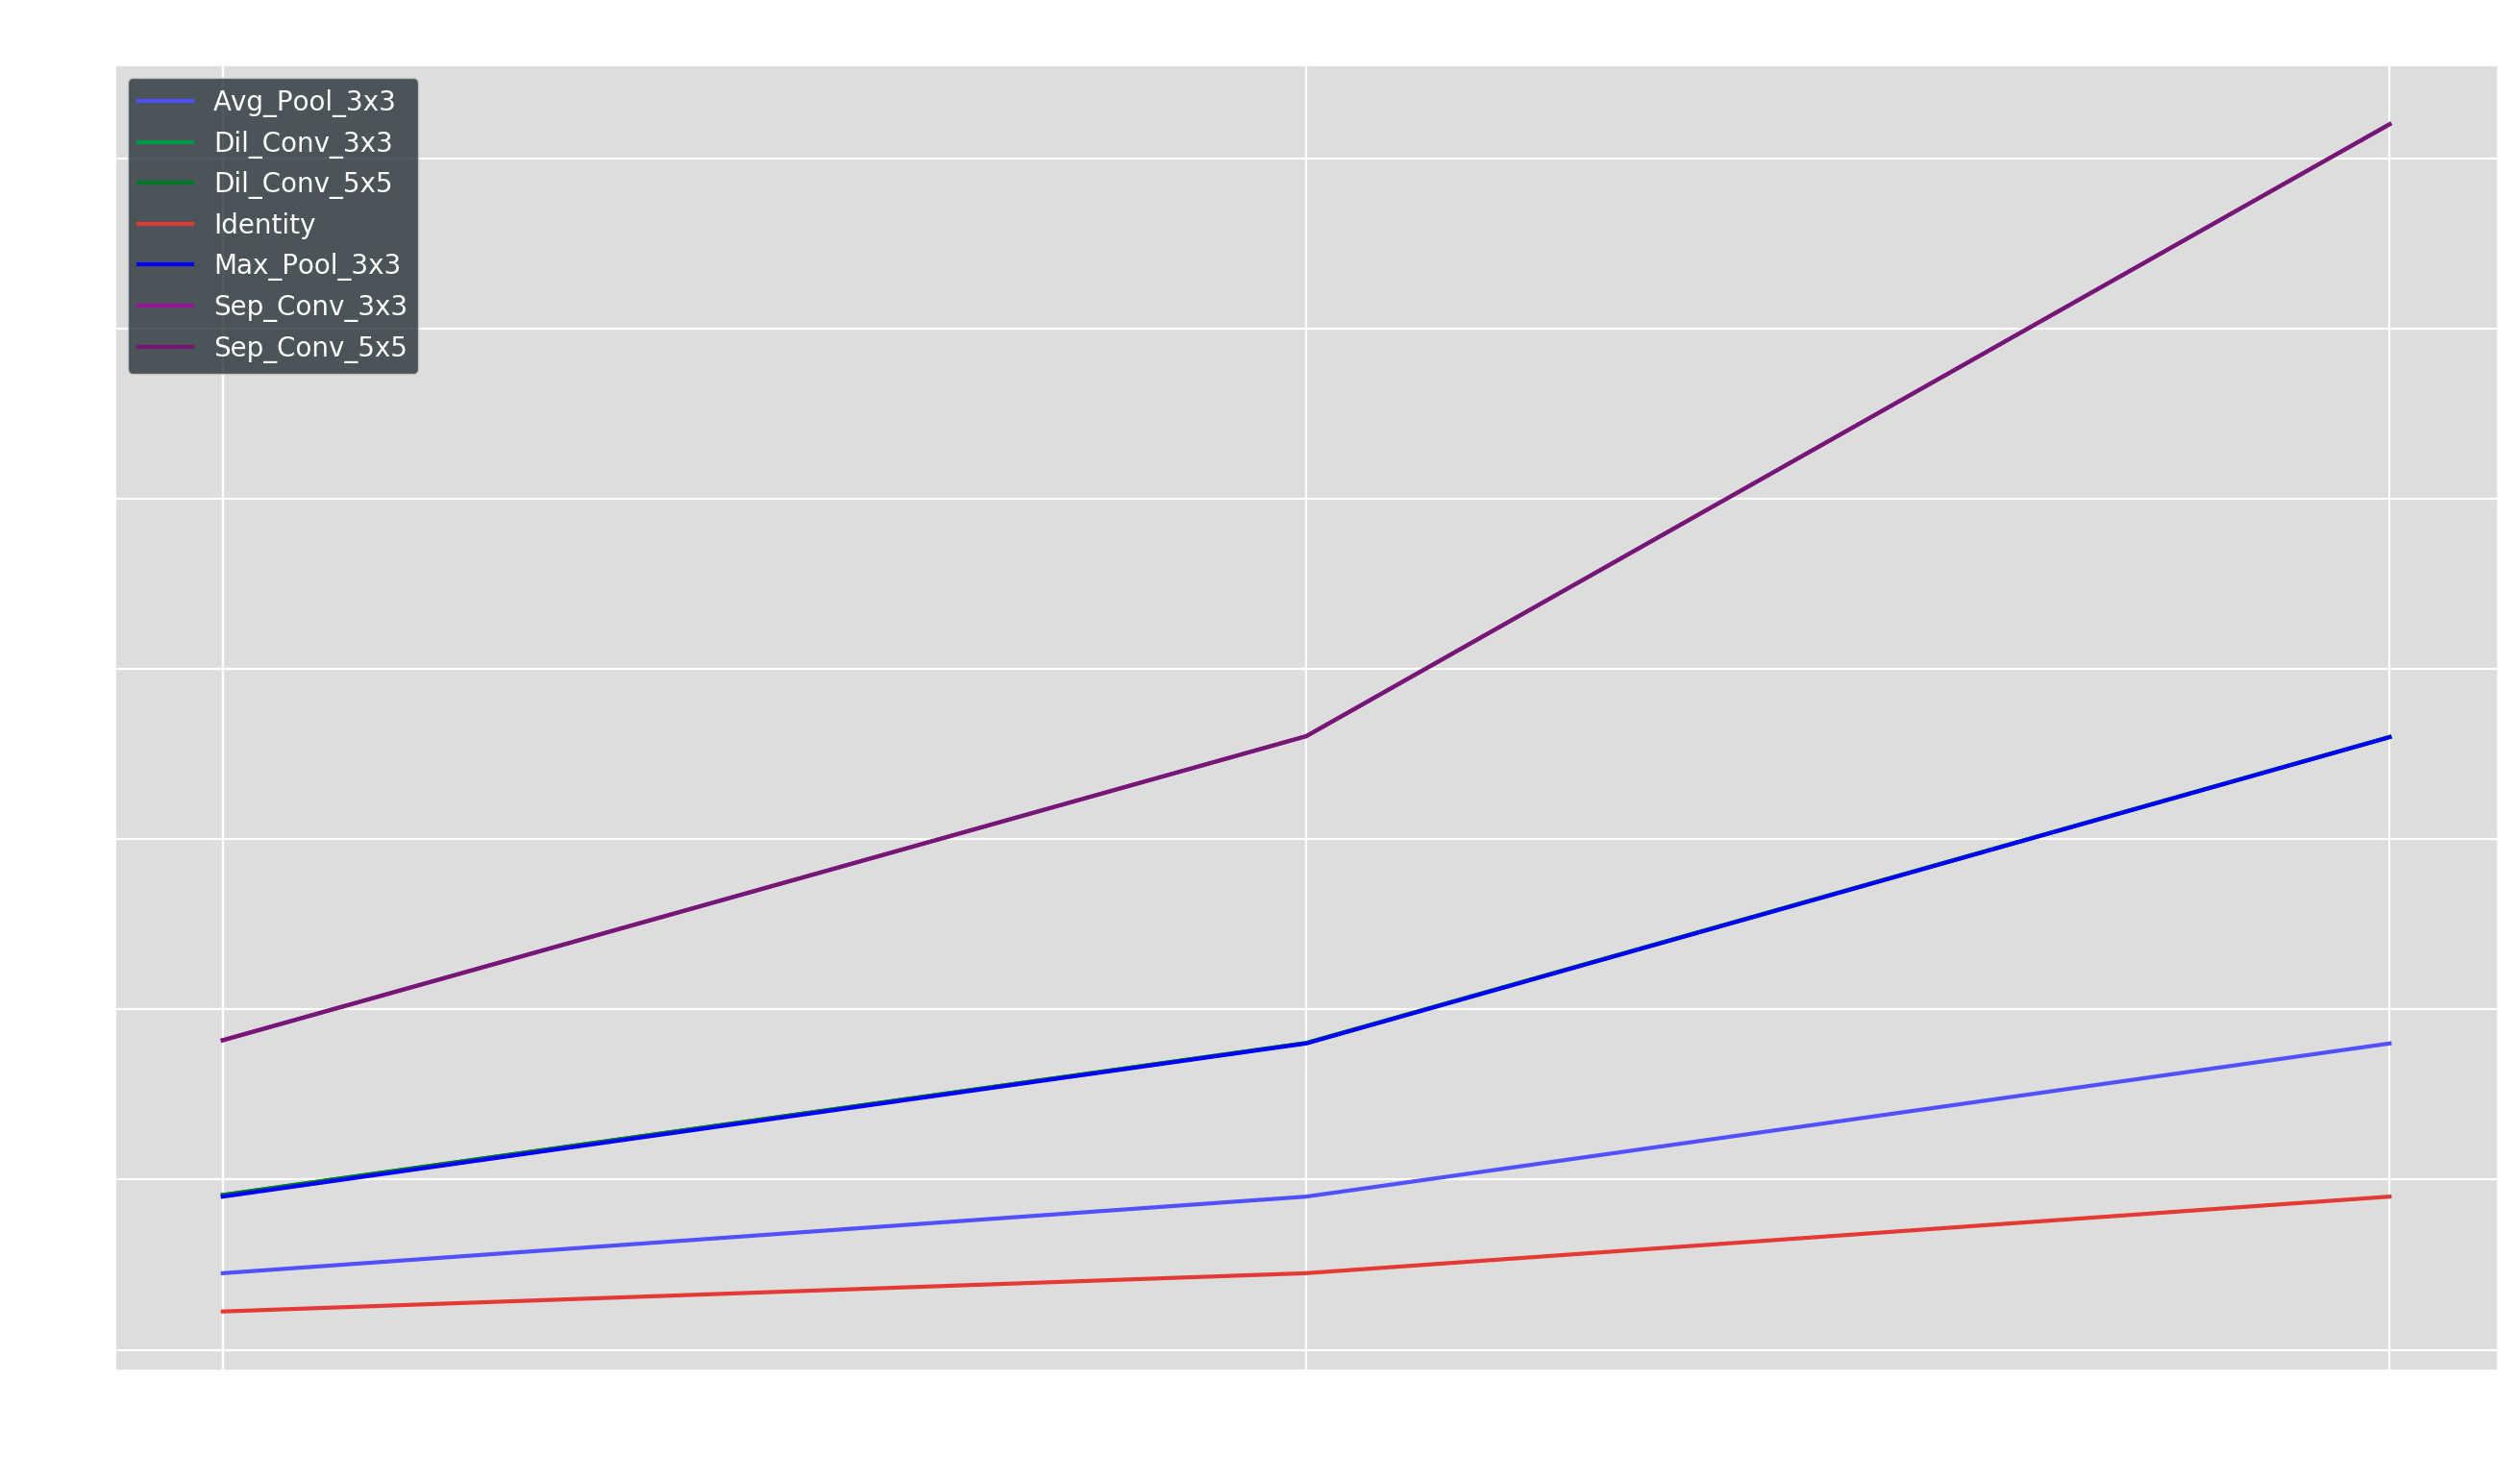

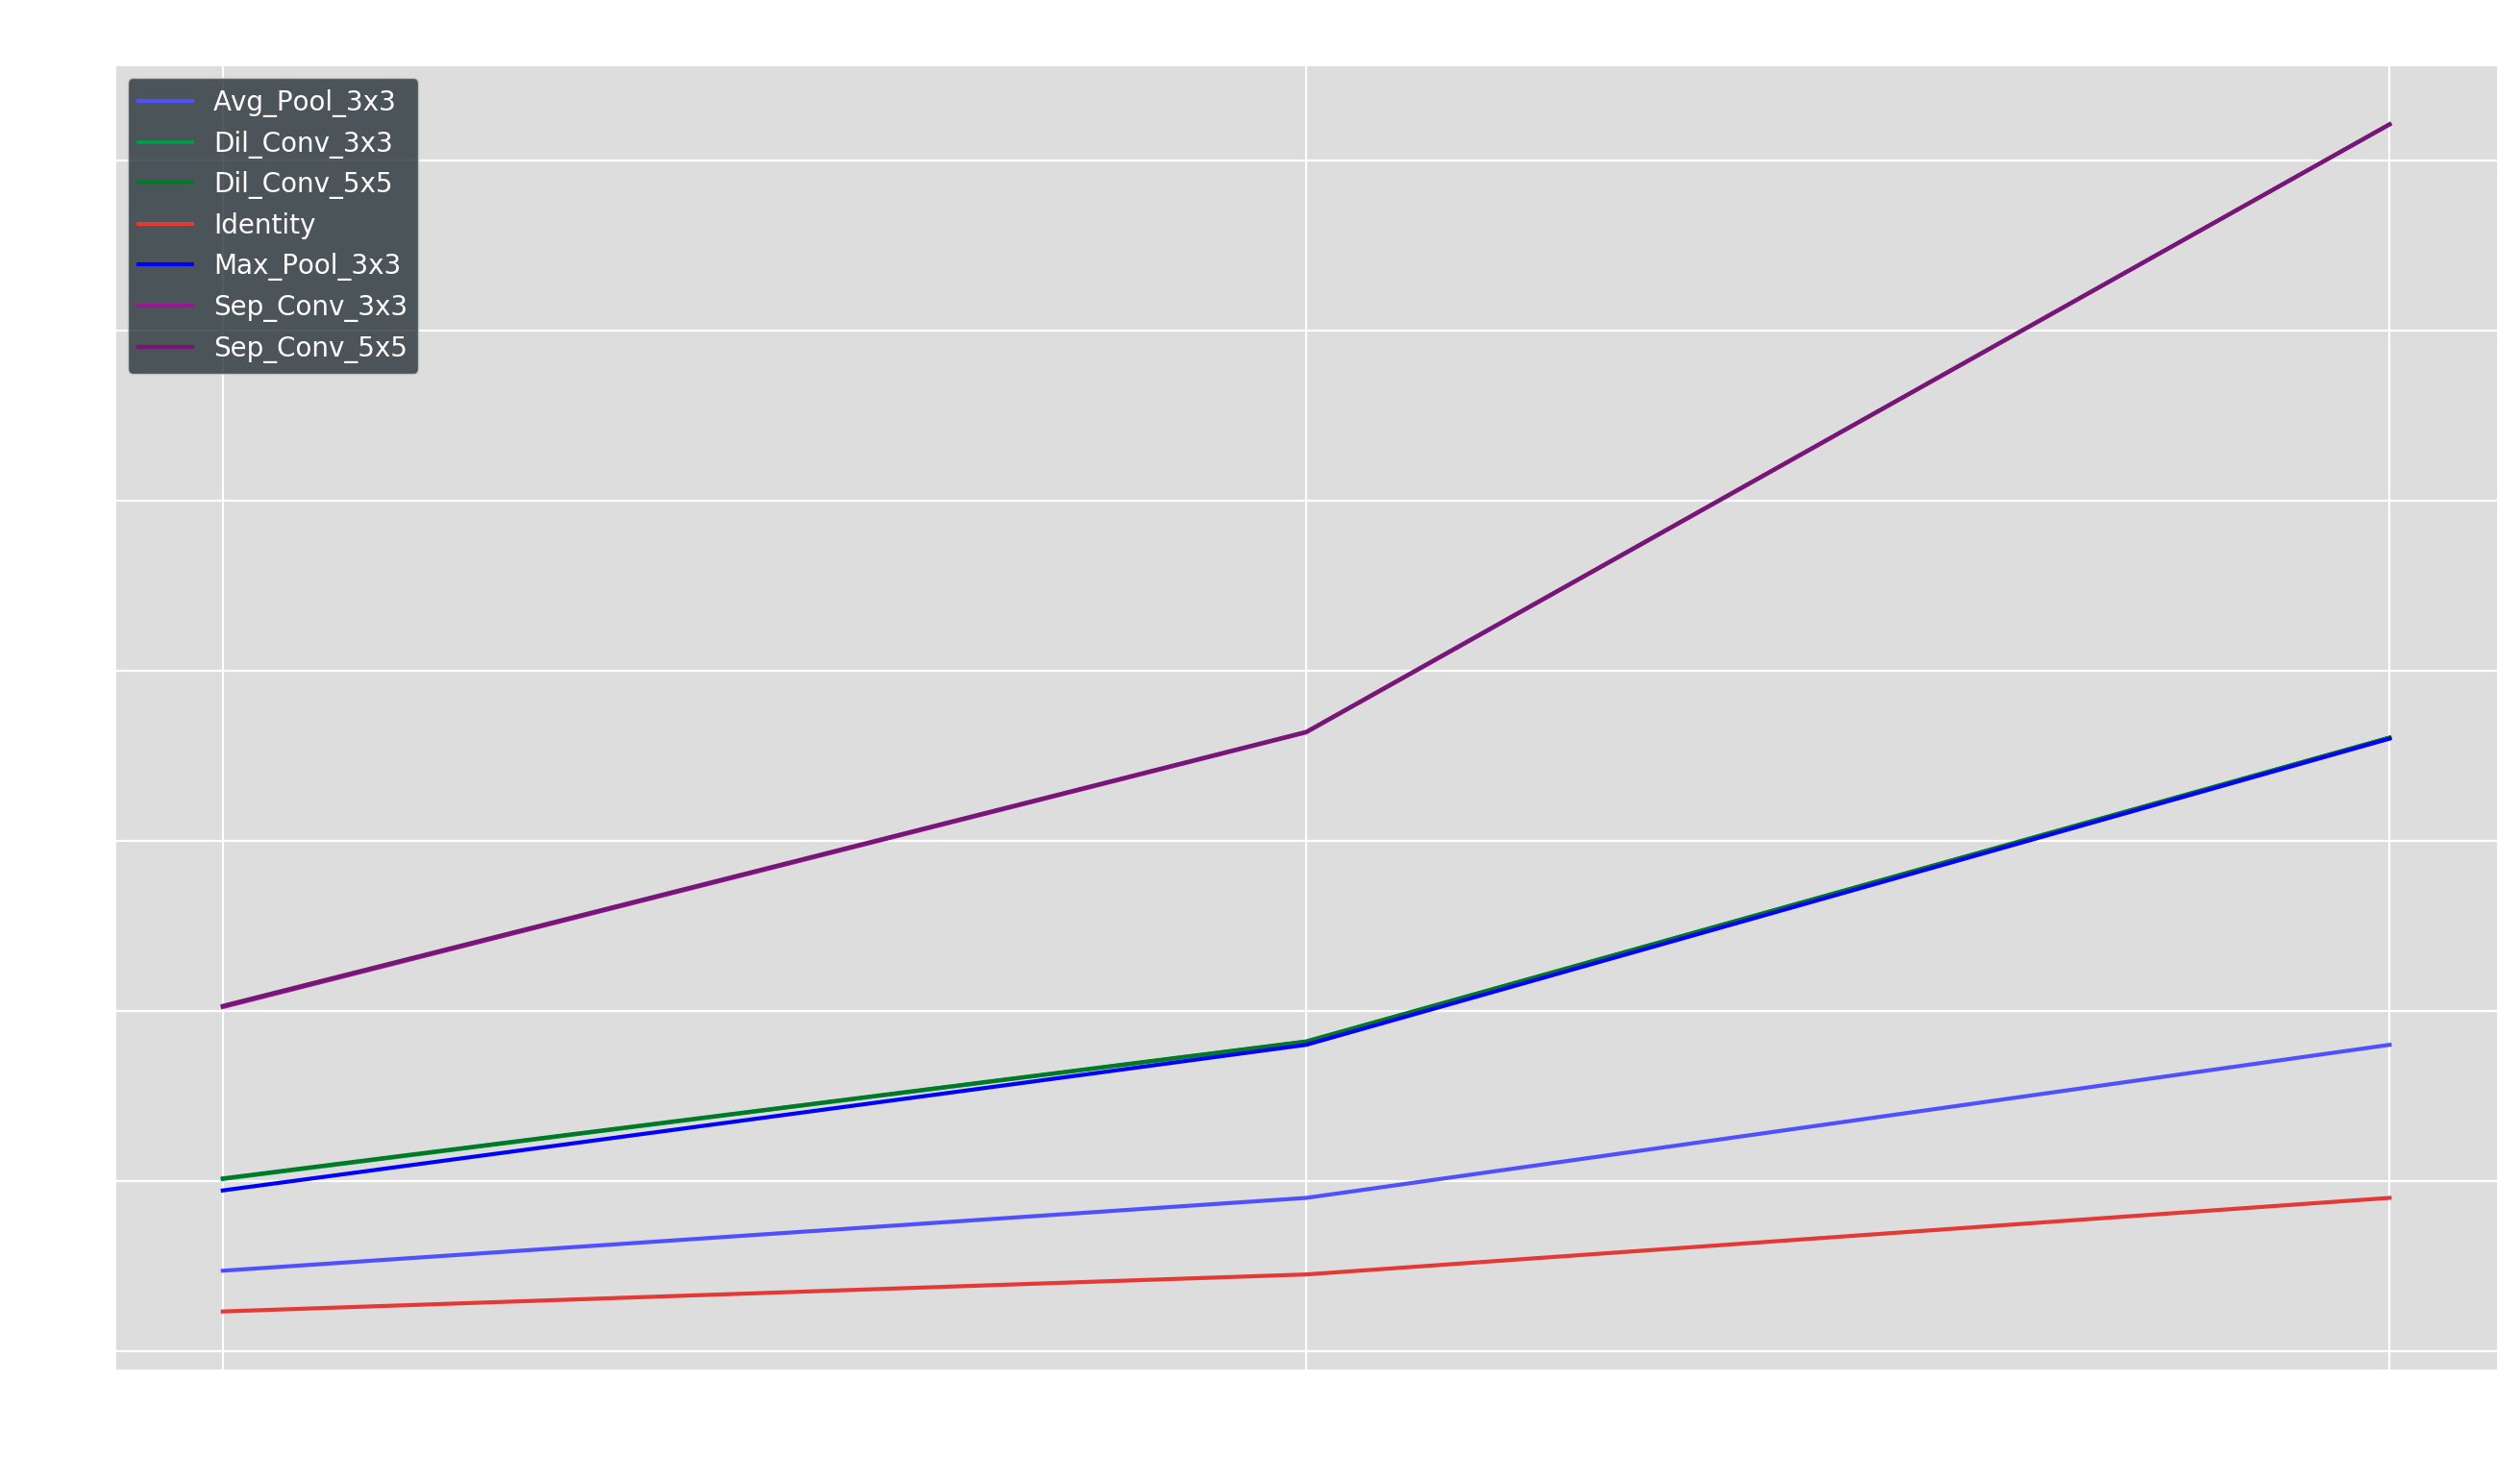

In [7]:
for stride in [1,2]:
    size_df = pd.DataFrame([{k:v for k,v in list(sizes.items())+[['size',key[1:-1]]]} for key,sizes in op_sizes.items() if key[-1]==stride])
    size_df['total_size']=size_df['size'].apply(lambda x: np.log2(x[0]*x[1]*x[2]))
    size_df = size_df.sort_values(by='total_size')
    plt.figure(figsize=(16,9),dpi=200)
    for col in list(size_df):
        if col not in ['size','total_size']:
            plt.plot(size_df['total_size'],size_df[col],color=colors[col]['hex'],label=col)
    fig, ax = plt.gcf(), plt.gca()
    plt.xlabel('log2(op_size)')
    plt.xticks(size_df['total_size'],size_df['size'])
    plt.ylabel('Size MB')
    plt.title("Stride {} Op Sizes".format(stride))
    ax.legend()

    plt.savefig('op_size_stride{}.png'.format(stride), facecolor='#263238', transparent=False)
    plt.show()

# Operation Frequencies

## Setup

In [34]:
ops = []
targets = ['genotype_POBox_Mel_Nantucket_r1','genotype_Cruz_Shari_Monsanto','genotype_Cheddar_Gujarat_Shakespeare']
for target in targets:
    params, genotype = pkl.load(open('genotypes/{}_np.pkl'.format(target), "rb"))

    cell_types, cell_positions, loop_idx = [], [], 0
    while len(cell_types) < len(genotype.items()):
        for i, pattern in enumerate(params['patterns']):
            for j, cell in enumerate(pattern):
                cell_positions.append([i + (loop_idx * len(params['patterns'])), j])
                cell_types.append(cell.upper()  if i else "N")
        loop_idx += 1


    for i, (cell_name, cell_genotype) in enumerate(genotype.items()):
        counts = collections.Counter()
        for key, val in cell_genotype.items():
            for v in val:
                if type(v) is not str:
                    weight = v[1] if type(v[1]) is int else v[1].item()
                    if key is not 'X' and key is not 'Y':
                        origin_node, target_node = key.split("->")
                        origin = '{}_{}'.format(cell_name, origin_node)
                        o, t = node_remap(origin_node), node_remap(target_node)
                        if 0:#cell_types[i] == 'R' and o <= 1 and v[0] == 'Identity':
                            op = 'Max_Pool_3x3'
                        else:
                            op = v[0]
                        
                        
                        counts[op]+=1
        out = {k:v for k,v in counts.items()}
        out['cell_type'] = cell_types[i]
        out['model']=target
        out['i']=i
        ops.append(out)
op_df = pd.DataFrame(ops).fillna(0)

In [35]:
def plot_bar(ax, cell, lim, label, title, idx):
    locs = np.arange(0,len(colors))
    for key, val in cell.items():
        ax.bar(colors[key]['pos'],val,color=colors[key]['hex'],label=key)

    ax.set_ylim(0,lim)
    if title:
        ax.set_title(title)
    if idx is not None:
        ax.set_ylabel(idx)
    if i>0:
        ax.set_yticklabels([])
        for tic in ax.yaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
    if label:
        ax.set_xticks(locs)
        ax.set_xticklabels(colors.keys(),rotation=90)
    else:
        ax.set_xticklabels([])

## by depth

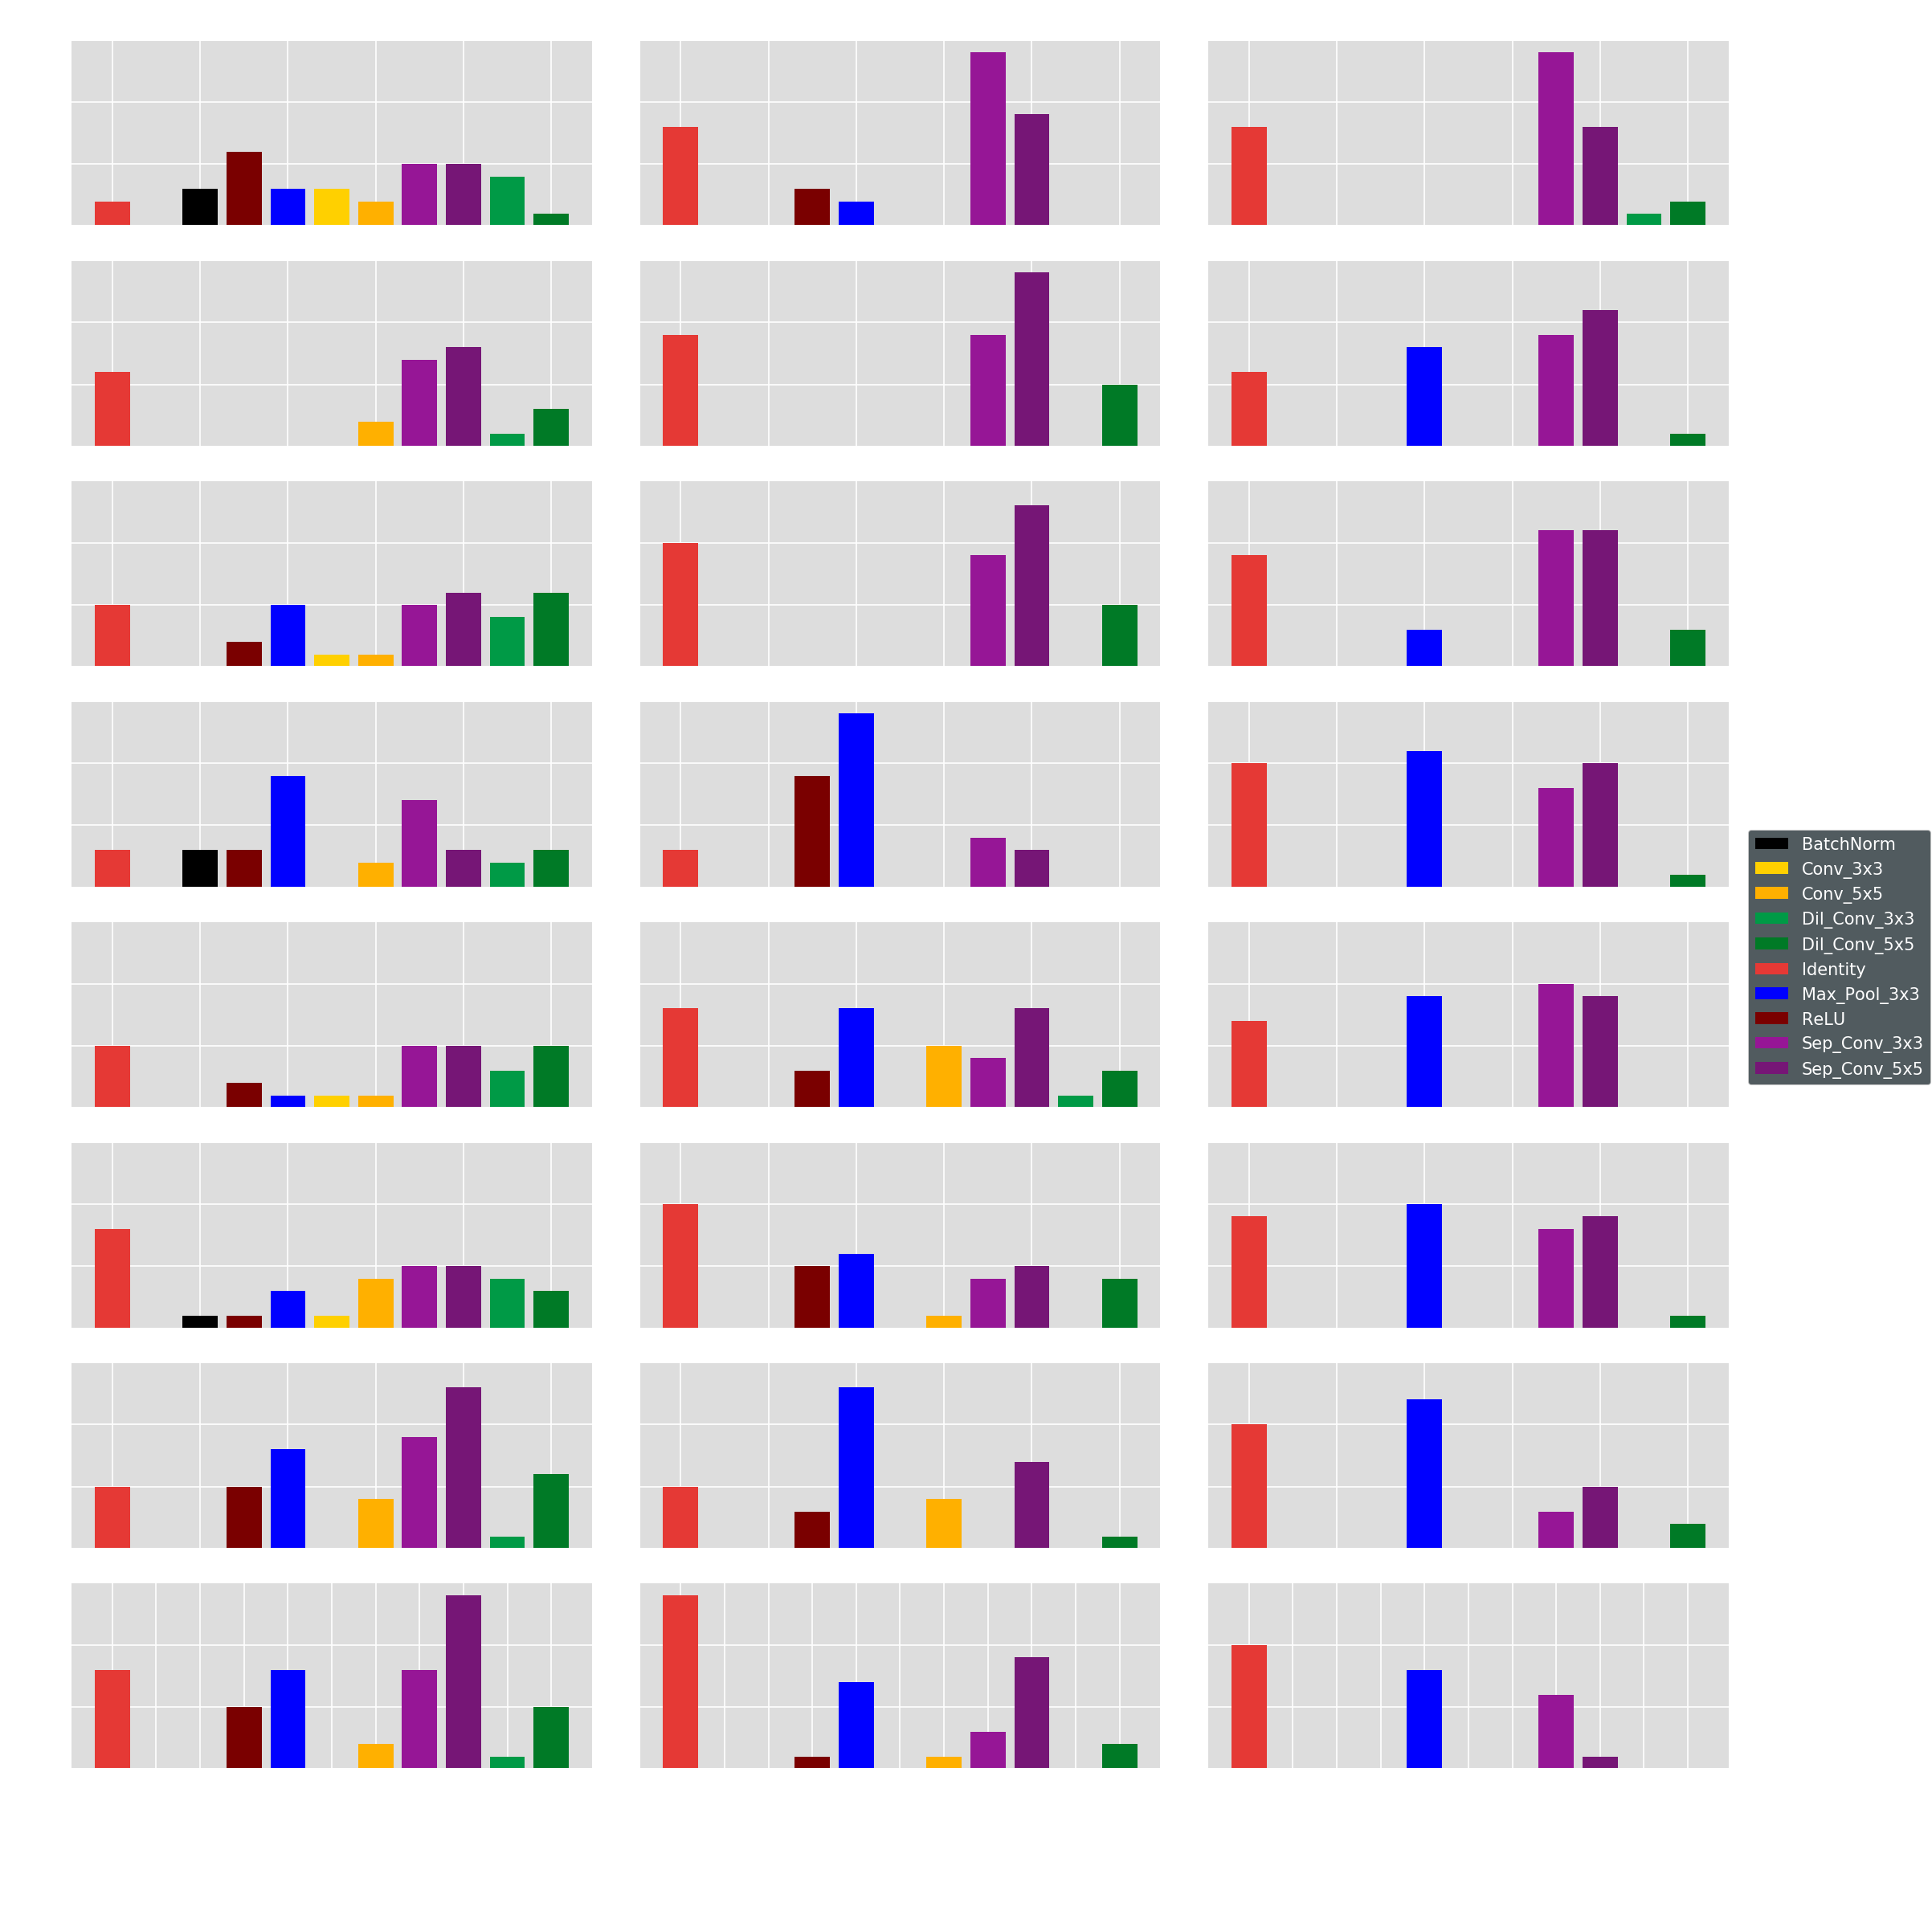

In [38]:
cells = [len(op_df[(op_df['model']==target)]) for target in targets]
fig, axes = plt.subplots(max(cells),len(targets), figsize=(16,16), dpi=150)
for i,target in enumerate(targets):
    for cell_idx in range(0, cells[i]):
        cell = op_df[(op_df['model']==target) & (op_df['i']==cell_idx)]
        cell = cell[[x for x in list(op_df) if x in colors.keys()]]
        plot_bar(axes[cell_idx][i], 
                 cell, 
                 lim=15,
                 label = cell_idx==7,
                 title=target if cell_idx==0 else None,
                 idx = "Cell {} ({})".format(cell_idx, cell_types[cell_idx]) if i==0 else None)

handles, labels = axes[-1][-1].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='center right',borderaxespad=0.1)
plt.tight_layout()
plt.subplots_adjust(right=0.9)
#plt.savefig('op_counts_by_depth.png', facecolor='#263238', transparent=False)
plt.show()

## by cell type

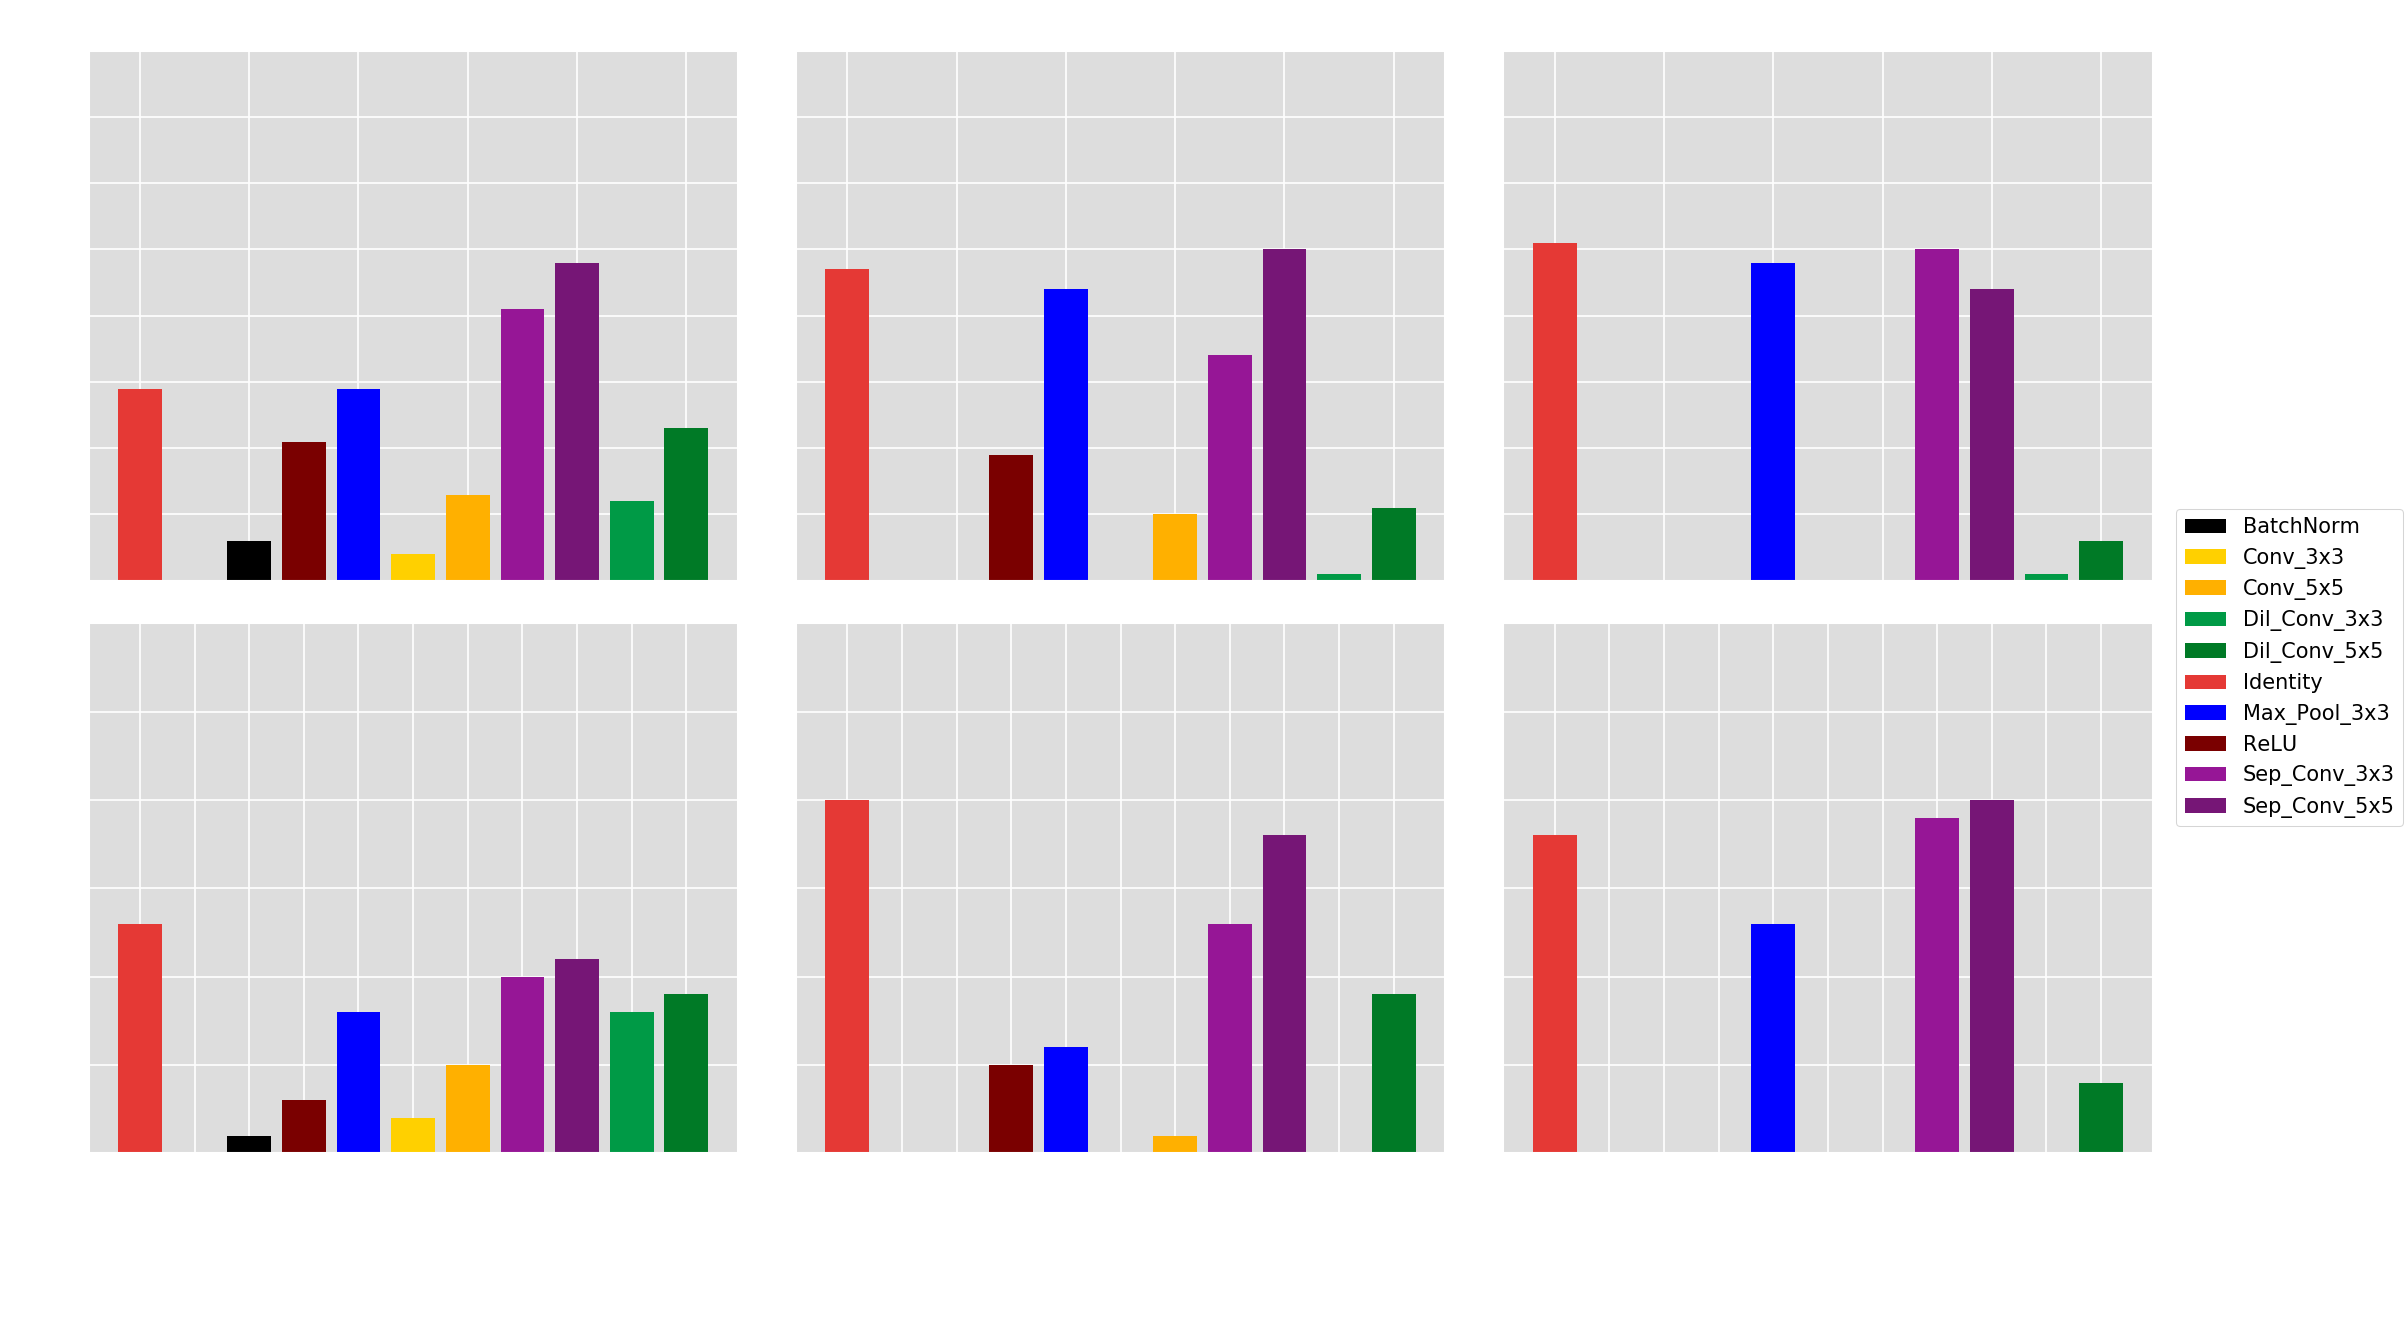

In [39]:
fig, axes = plt.subplots(2,len(targets), figsize=(16,9), dpi=150)
for i,target in enumerate(targets):
    type_df = op_df[op_df['model']==target].groupby('cell_type')[[x for x in list(op_df) if x in colors.keys()]].sum()
    for cell_idx, cell_type in enumerate(['N','R']):
        cell = type_df.loc[cell_type].to_dict()
        plot_bar(axes[cell_idx][i], 
                 cell, 
                 lim=80 if cell_type=='N' else 30,
                 label = cell_type=='R',
                 title=target if cell_idx==0 else None, 
                 idx="{} Cells".format('Normal' if cell_type is 'N' else 'Reduction')  if i==0 else None)

handles, labels = axes[-1][-1].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='center right',borderaxespad=0.1, facecolor='white')
plt.setp(legend.get_texts(), color='k')
plt.tight_layout()
plt.subplots_adjust(right=0.9)
#plt.savefig('cell_types_by_model.png', facecolor='#263238', transparent=False)
plt.show()

# GIFing

In [8]:
import glob
from PIL import Image, ImageDraw, ImageOps, ImageFont

# filepaths
fp_in = "chroma_ims/*.png"
fp_out = "chroma.gif"
files = sorted(glob.glob(fp_in))

max_size = [Image.open(f).size for f in files]
scale = 10
max_w,max_h = max(max_size,key=lambda x: x[0])[0]//scale, max(max_size,key=lambda x: x[1])[1]//scale

ims = []
for i,f in enumerate(files):
    im = Image.open(f)
    im = im.resize([im.size[0]//scale,im.size[1]//scale])
    draw = ImageDraw.Draw(im)
    draw.text((5,0),"{}/{}".format(i,len(file_nums)),(0,0,0), fontsize=26)
    new_im = ImageOps.expand(im, (0,max_w-im.size[0],0,max_h-im.size[1]),fill = (255,255,255))
    new_im.save('chroma_ims/proc/im_{:03d}.png'.format(i))

NameError: name 'file_nums' is not defined